In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
filename = 'kindle_reduced_clean.csv'
df = spark.read.csv(filename,  inferSchema=True, header = True)

In [4]:
df.select("overall","summary","reviewText").show(5)

+-------+--------------------+--------------------+
|overall|             summary|          reviewText|
+-------+--------------------+--------------------+
|      5|  A Very Sexy Cruise|ARC provided by a...|
|      5|A Changing Gears ...|Wild Ride by Nanc...|
|      5|We don't take kin...|Well thought out ...|
|      3|Mediocre Science ...|Being autistic, I...|
|      3| I'm losing interest|This is book four...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [5]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----+-------+-------+----------+----------+----------+------------+-------+--------------+--------------+----------+--------------+
|index|asin|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|HelpfulRecords|HasHelpful|weightedRating|
+-----+----+-------+-------+----------+----------+----------+------------+-------+--------------+--------------+----------+--------------+
|    0|   0|      0|      0|         1|         0|         0|          24|      0|             0|             0|         0|             0|
+-----+----+-------+-------+----------+----------+----------+------------+-------+--------------+--------------+----------+--------------+



In [6]:
df = df.dropna(how='any')

In [7]:
df=df.drop("index","reviewerName","unixReviewTime","helpful","HasHelpful")

In [8]:
df = df.withColumn('reviewText', translate('reviewText', '.', ''))
df = df.withColumn('reviewText', translate('reviewText', ',', ''))
df = df.withColumn('reviewText', translate('reviewText', '$', ''))

In [9]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

#tokenize text (make words into an array)
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_token')
df_token = tokenizer.transform(df).select('*')

#remove basic words
remover = StopWordsRemover(inputCol='reviewText_token', outputCol='reviewText_clean')
df_stop=remover.transform(df_token).select('*')

In [10]:
#tokenize summaries (make words into an array)
tokenizer = Tokenizer(inputCol='summary', outputCol='summary_token')
df_token = tokenizer.transform(df_stop).select('*')

#remove basic words
remover = StopWordsRemover(inputCol='summary_token', outputCol='summary_clean')
df_stop=remover.transform(df_token).select('*')

In [11]:
df_stop=df_stop.drop("reviewText", "summary","reviewText_token", "summary_token")
df_stop.show(5)

+----------+-------+-----------+--------------+--------------+--------------+--------------------+--------------------+
|      asin|overall| reviewTime|    reviewerID|HelpfulRecords|weightedRating|    reviewText_clean|       summary_clean|
+----------+-------+-----------+--------------+--------------+--------------+--------------------+--------------------+
|B00J4S6YWC|      5|06 21, 2014| AUSBN91MCI3WM|           0.0|           5.0|[arc, provided, a...|      [sexy, cruise]|
|B00HCZUBH8|      5| 03 3, 2014|A141H51I3H4B1S|           0.5|           5.0|[wild, ride, nanc...|[changing, gears,...|
|B006RZNR3Y|      5|07 10, 2014| AP8TKDM76TROZ|           0.0|           4.0|[well, thought, s...| [take, kindly, no!]|
|B006RZNR3Y|      3| 02 1, 2014|A22GGHISKRVAOX|           0.0|           4.0|[autistic, freque...|[mediocre, scienc...|
|B00J47H8H8|      3|03 21, 2014|A19DWIC1T7127Y|          0.75|           3.0|[book, four, five...|  [losing, interest]|
+----------+-------+-----------+--------

In [12]:
display(df_stop.select("reviewText_clean"))

DataFrame[reviewText_clean: array<string>]

In [13]:
df_stop.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- HelpfulRecords: double (nullable = true)
 |-- weightedRating: double (nullable = true)
 |-- reviewText_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- summary_clean: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [14]:
df_stop.show(5)

+----------+-------+-----------+--------------+--------------+--------------+--------------------+--------------------+
|      asin|overall| reviewTime|    reviewerID|HelpfulRecords|weightedRating|    reviewText_clean|       summary_clean|
+----------+-------+-----------+--------------+--------------+--------------+--------------------+--------------------+
|B00J4S6YWC|      5|06 21, 2014| AUSBN91MCI3WM|           0.0|           5.0|[arc, provided, a...|      [sexy, cruise]|
|B00HCZUBH8|      5| 03 3, 2014|A141H51I3H4B1S|           0.5|           5.0|[wild, ride, nanc...|[changing, gears,...|
|B006RZNR3Y|      5|07 10, 2014| AP8TKDM76TROZ|           0.0|           4.0|[well, thought, s...| [take, kindly, no!]|
|B006RZNR3Y|      3| 02 1, 2014|A22GGHISKRVAOX|           0.0|           4.0|[autistic, freque...|[mediocre, scienc...|
|B00J47H8H8|      3|03 21, 2014|A19DWIC1T7127Y|          0.75|           3.0|[book, four, five...|  [losing, interest]|
+----------+-------+-----------+--------

# Exploratory Data Analysis

In [15]:
df_stop.describe().show()

+-------+----------+-----------------+----------+-------------+------------------+------------------+
|summary|      asin|          overall|reviewTime|   reviewerID|    HelpfulRecords|    weightedRating|
+-------+----------+-----------------+----------+-------------+------------------+------------------+
|  count|      4880|             4880|      4880|         4880|              4880|              4880|
|   mean|      null|4.340573770491804|      null|         null|0.3715991527158007|  4.34097108502769|
| stddev|      null|0.973934363172232|      null|         null|0.4611430329911328|0.9374090879340996|
|    min|B000SRGF2W|                1|01 1, 2011| A0JVI0NYIOT2|               0.0|               1.0|
|    max|B00LYPZIXO|                5|12 9, 2013|AZZFLSL2LE4FX|               1.0| 5.000000000000001|
+-------+----------+-----------------+----------+-------------+------------------+------------------+



## Word 2 Vec

In [23]:
word_vec=df_stop.select("reviewText_clean")

In [32]:
word_vec.show(5)

+--------------------+
|       summary_clean|
+--------------------+
|      [sexy, cruise]|
|[changing, gears,...|
| [take, kindly, no!]|
|[mediocre, scienc...|
|  [losing, interest]|
+--------------------+
only showing top 5 rows



In [27]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=5, seed=42, inputCol="reviewText_clean", outputCol="model")
word2Vec.setMaxIter(10)
#Word2Vec...
word2Vec.getMaxIter()
10
word2Vec.clear(word2Vec.maxIter)
model = word2Vec.fit(word_vec)
model.getMinCount()
5
model.setInputCol("words_clean")

#Word2VecModel...
model.getVectors().show(10,truncate=False)

+----------+----------------------------------------------------------------------------------------------------------+
|word      |vector                                                                                                    |
+----------+----------------------------------------------------------------------------------------------------------+
|clarissa  |[-0.08527789264917374,-0.061181358993053436,0.04229581356048584,0.13291782140731812,-0.020387664437294006]|
|incident  |[-0.17075666785240173,0.026323946192860603,-0.06936486065387726,0.028995148837566376,-0.1795503944158554] |
|serious   |[-0.17508743703365326,0.12439662963151932,-0.06705012172460556,0.10328210890293121,-0.18280819058418274]  |
|breaks    |[-0.09439557045698166,0.07781413197517395,-0.15210963785648346,0.06119786947965622,-0.2311510592699051]   |
|forgotten |[-0.0568401962518692,0.0626450851559639,-0.001981329172849655,-0.03409483656287193,-0.0365166962146759]   |
|precious  |[-0.15493319928646088,0.0950

In [28]:
word_vec=df_stop.select("summary_clean")

In [30]:
word2Vec = Word2Vec(vectorSize=5, seed=42, inputCol="summary_clean", outputCol="model")
word2Vec.setMaxIter(10)
#Word2Vec...
word2Vec.getMaxIter()
10
word2Vec.clear(word2Vec.maxIter)
model = word2Vec.fit(word_vec)
model.getMinCount()
5
model.setInputCol("words_clean")

#Word2VecModel...
model.getVectors().show(10,truncate=False)

+---------+------------------------------------------------------------------------------------------------------------+
|word     |vector                                                                                                      |
+---------+------------------------------------------------------------------------------------------------------------+
|ideas    |[0.07896555960178375,0.08228708803653717,-0.0314699150621891,-0.05050545558333397,-0.01455814577639103]     |
|sweet    |[-0.0714794397354126,-0.07245013117790222,-0.008758701384067535,-0.05772051960229874,0.1064988225698471]    |
|beautiful|[0.016373470425605774,-0.09401625394821167,-0.09978445619344711,0.01230132207274437,0.010742578655481339]   |
|writing  |[0.1669931560754776,-0.09632845968008041,-0.023153474554419518,-0.05083288624882698,0.07983992248773575]    |
|funny    |[0.05766937509179115,-0.10599081218242645,-0.0632324367761612,-0.01607191003859043,-0.0852198451757431]     |
|weird    |[-0.01986339129507541

## Word Cloud

In [35]:
#!pip install wordcloud

In [101]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
from os import path

In [102]:
reviews=df_stop.select("reviewText_clean")
reviews=reviews.toPandas()

In [104]:
text=reviews['reviewText_clean'].apply(', '.join)

In [105]:
text = ", ".join(review for review in text)

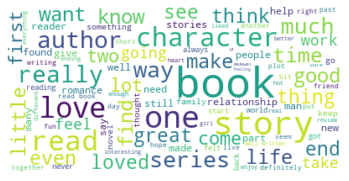

In [106]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [109]:
wordcloud.to_file("amazon.png")

In [111]:
reviews=df_stop.select("summary_clean")
reviews=reviews.toPandas()
text=reviews['summary_clean'].apply(', '.join)
text = ", ".join(review for review in text)

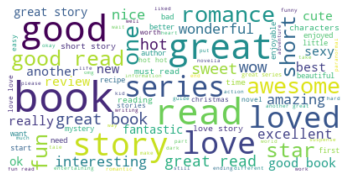

In [112]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [113]:
wordcloud.to_file("summary.png")

## Histogram

In [117]:
df_pd=df_stop.toPandas()

Text(0.5, 1.0, 'Count of Ratings')

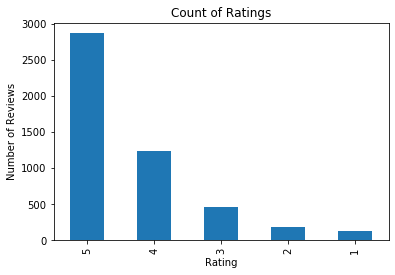

In [134]:
df_pd.overall.value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title("Count of Ratings")

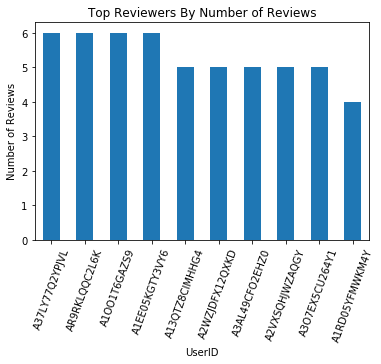

In [138]:
df_pd.reviewerID.value_counts().head(10).plot(kind = 'bar')
plt.xticks(rotation = 70)
plt.xlabel('UserID')
plt.ylabel('Number of Reviews')
plt.title("Top Reviewers By Number of Reviews")
plt.show()

In [1]:
!jupyter nbconvert --to pdf `pwd`/*.ipynb

[NbConvertApp] Converting notebook /home/jovyan/project/amazon_reviews_3_17_10pm.ipynb to pdf
/opt/conda/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 52151 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 43162 bytes to /home/jovyan/project/amazon_reviews_3_17_10pm.pdf
[NbConvertApp] Converting notebook /home/jovyan/project/amazon_reviews_eda.ipynb to pdf
[NbConvertApp] Support files will be in amazon_reviews_eda_files/
[NbConvertApp] Making directory ./amazon_reviews_eda_files
[NbConvertApp] Making directory ./amazon_revie